<a href="https://colab.research.google.com/github/Lais-Maranhao/projeto-final-desenvolve/blob/codespace-fictional-spoon-q7qg4prx5rqfxq6/C%C3%B3pia_de_proj_final_t2g9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports e Configs

In [ ]:
!pip install google-cloud-bigquery
from google.cloud import bigquery
from google.colab import auth
!pip install pandas scikit-learn matplotlib seaborn joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
%matplotlib inline

## 0.1 Login BigQuery

In [ ]:
## Autenticação do Google -- mesmo usuário do BQ

auth.authenticate_user()

# 1. Load Dataset

In [ ]:
main_project = bigquery.Client(project='t1engenhariadados')

In [ ]:
select_train_data = """
SELECT *
FROM `t1engenhariadados.turma2_grupo9.train_data`
"""
train = main_project.query(select_train_data).to_dataframe()

In [ ]:
select_test_data = """
SELECT *
FROM `t1engenhariadados.turma2_grupo9.test_data`
"""
test = main_project.query(select_test_data).to_dataframe()

# 2. Exploração Inicial dos Dados
Vamos inspecionar as primeiras linhas do dataset, verificar os tipos de dados e a presença de valores nulos.

In [ ]:
df = train

In [ ]:
print("Primeiras 5 linhas do dataset:")
df.head()

Primeiras 5 linhas do dataset:


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1604,1,d,10,Y,3,TB & Chest disease,Q,B,3.0,90754,8.0,Emergency,Extreme,3,91-100,4360.0,11-20
1,19096,1,d,10,Y,2,gynecology,Q,B,3.0,14675,8.0,Emergency,Minor,2,91-100,5442.0,11-20
2,74929,1,d,10,Y,4,gynecology,R,B,1.0,38742,8.0,Urgent,Moderate,4,91-100,3794.0,21-30
3,81312,1,d,10,Y,4,gynecology,T,B,2.0,90960,8.0,Emergency,Moderate,4,91-100,3056.0,51-60
4,172976,1,d,10,Y,4,gynecology,R,B,1.0,102482,8.0,Trauma,Extreme,3,91-100,4899.0,41-50


In [ ]:
print("\nInformações sobre o dataset:")
df.info()


Informações sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  Int64  
 1   Hospital_code                      318438 non-null  Int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  Int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  Int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  Int64  
 11  City_Code

## 3. Análise Estatística Descritiva
Será realizada uma análise estatística descritiva para as colunas numéricas e categóricas.

In [ ]:
print("Estatísticas descritivas para todas as colunas:")
print(df.describe)

Estatísticas descritivas para todas as colunas:
<bound method NDFrame.describe of         case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0          1604              1                  d                  10   
1         19096              1                  d                  10   
2         74929              1                  d                  10   
3         81312              1                  d                  10   
4        172976              1                  d                  10   
...         ...            ...                ...                 ...   
318433   302375             32                  f                   9   
318434   302541             32                  f                   9   
318435   303014             32                  f                   9   
318436   317450             32                  f                   9   
318437   318404             32                  f                   9   

       Hospital_region_code  Available Ex

In [ ]:
# # Limpeza básica: duplicatas, outliers, variáveis correlacionadas (manual), categorias raras
# num_cols = train_data_limpo.select_dtypes(include=['float64', 'int64']).columns
# for col in num_cols:
#     Q1 = train_data_limpo[col].quantile(0.25)
#     Q3 = train_data_limpo[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lim_inf = Q1 - 1.5 * IQR
#     lim_sup = Q3 + 1.5 * IQR
#     train_data_limpo = train_data_limpo[(train_data_limpo[col] >= lim_inf) & (train_data_limpo[col] <= lim_sup)]
# # Visualize a matriz de correlação para decidir manualmente quais colunas remover
# print(train_data_limpo[num_cols].corr())
# # Exemplo: para remover manualmente, use algo assim:
# train_data_limpo = train_data_limpo.drop(columns=['case_id', 'patientid'])
# cat_cols = train_data_limpo.select_dtypes(include=['object', 'category']).columns
# for col in cat_cols:
#     freq = train_data_limpo[col].value_counts(normalize=True)
#     raras = freq[freq < 0.01].index
#     # train_data_limpo[col] = train_data_limpo[col].replace(raras, 'OUTRA')
# # train_data_limpo.to_csv('../data/train_data_limpo.csv', index=False)

                                    case_id  Hospital_code  \
case_id                            1.000000      -0.044041   
Hospital_code                     -0.044041       1.000000   
City_Code_Hospital                -0.010709       0.132887   
Available Extra Rooms in Hospital  0.036968      -0.064739   
Bed Grade                          0.012539      -0.012496   
patientid                         -0.003181       0.003149   
City_Code_Patient                  0.014084      -0.003646   
Visitors with Patient              0.003279      -0.030346   
Admission_Deposit                 -0.061437       0.047036   

                                   City_Code_Hospital  \
case_id                                     -0.010709   
Hospital_code                                0.132887   
City_Code_Hospital                           1.000000   
Available Extra Rooms in Hospital           -0.042211   
Bed Grade                                   -0.051365   
patientid                            

# 5. Análise de Padrões e Correlações
Vamos investigar as correlações entre as variáveis numéricas e a relação entre variáveis categóricas e a duração da internação (`Stay`).
## 5.1 Matriz de Correlação (Variáveis Numéricas)

In [ ]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

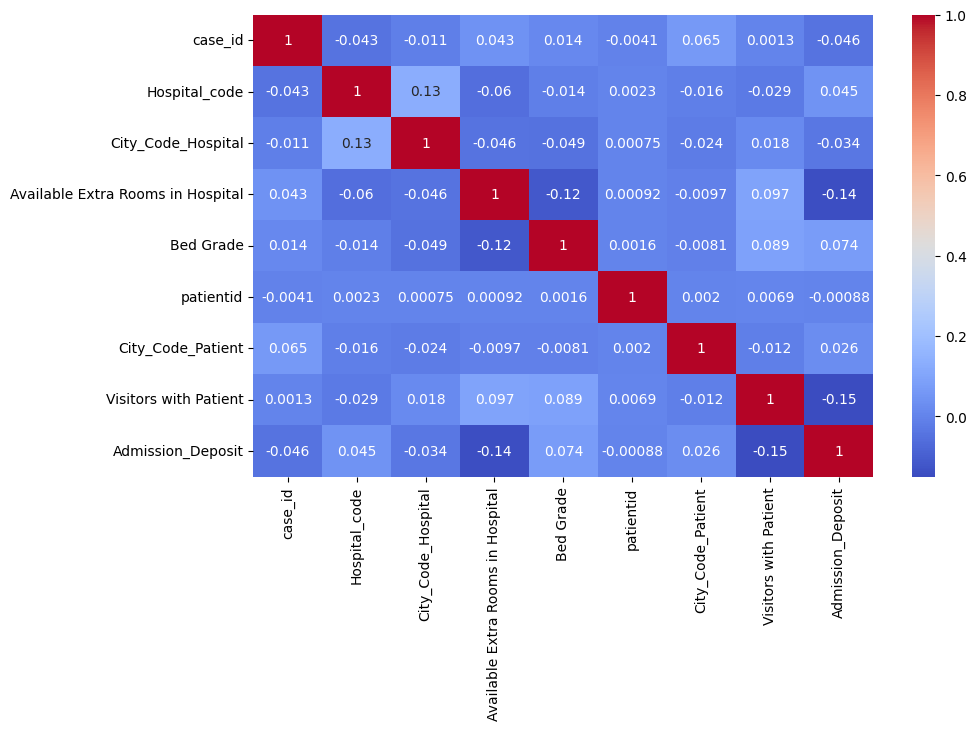

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.show()

## 5.2 Análise de Variáveis Categóricas em Relação à Duração da Estadia (`Stay`)

In [ ]:
print("Value counts for Stay:")
print(df["Stay"].value_counts().to_markdown())
print("\nStay vs Hospital_type_code:")
print(df.groupby("Hospital_type_code")["Stay"].value_counts(normalize=True).unstack().to_markdown())
print("\nStay vs Department:")
print(df.groupby("Department")["Stay"].value_counts(normalize=True).unstack().to_markdown())
print("\nStay vs Ward_Type:")
print(df.groupby("Ward_Type")["Stay"].value_counts(normalize=True).unstack().to_markdown())
print("\nStay vs Severity of Illness:")
print(df.groupby("Severity of Illness")["Stay"].value_counts(normalize=True).unstack().to_markdown())
print("\nStay vs Age:")
print(df.groupby("Age")["Stay"].value_counts(normalize=True).unstack().to_markdown())


Value counts for Stay:
| Stay               |   count |
|:-------------------|--------:|
| 21-30              |   87491 |
| 11-20              |   78139 |
| 31-40              |   55159 |
| 51-60              |   35018 |
| 0-10               |   23604 |
| 41-50              |   11743 |
| 71-80              |   10254 |
| More than 100 Days |    6683 |
| 81-90              |    4838 |
| 91-100             |    2765 |
| 61-70              |    2744 |

Stay vs Hospital_type_code:
| Hospital_type_code   |      0-10 |    11-20 |    21-30 |    31-40 |     41-50 |    51-60 |      61-70 |     71-80 |     81-90 |     91-100 |   More than 100 Days |
|:---------------------|----------:|---------:|---------:|---------:|----------:|---------:|-----------:|----------:|----------:|-----------:|---------------------:|
| a                    | 0.0736204 | 0.277546 | 0.280885 | 0.167154 | 0.0286631 | 0.101914 | 0.00644239 | 0.0259508 | 0.0131776 | 0.00670734 |            0.0179397 |
| b                  

## 5.3 Visualização de Dados
Serão geradas visualizações para entender melhor a distribuição da duração da internação e sua relação com a gravidade da doença e a idade.

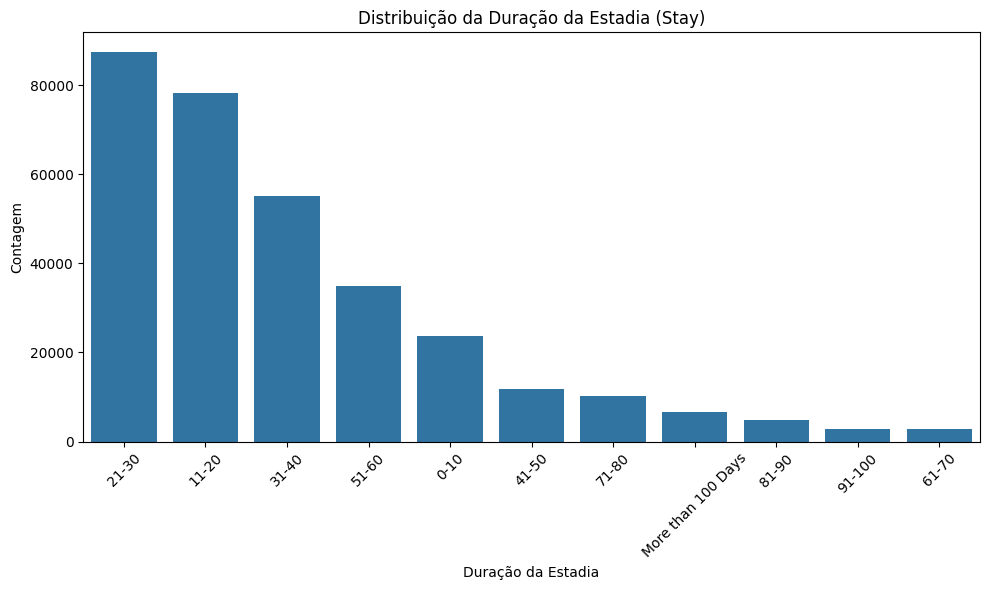

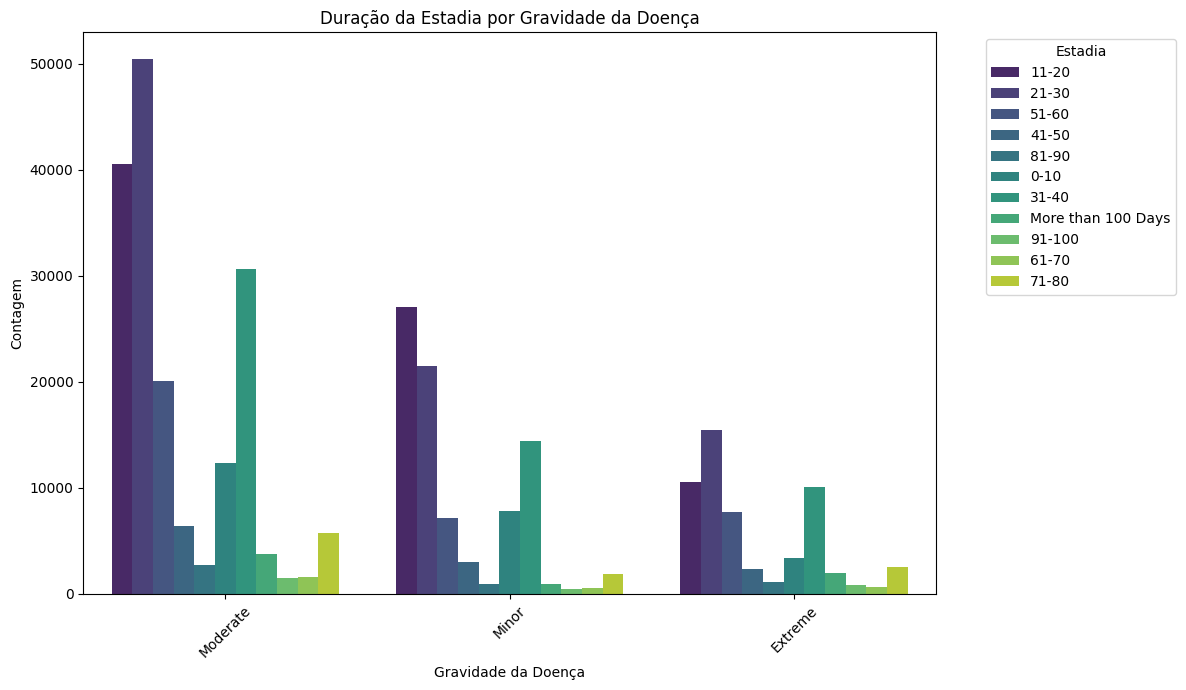

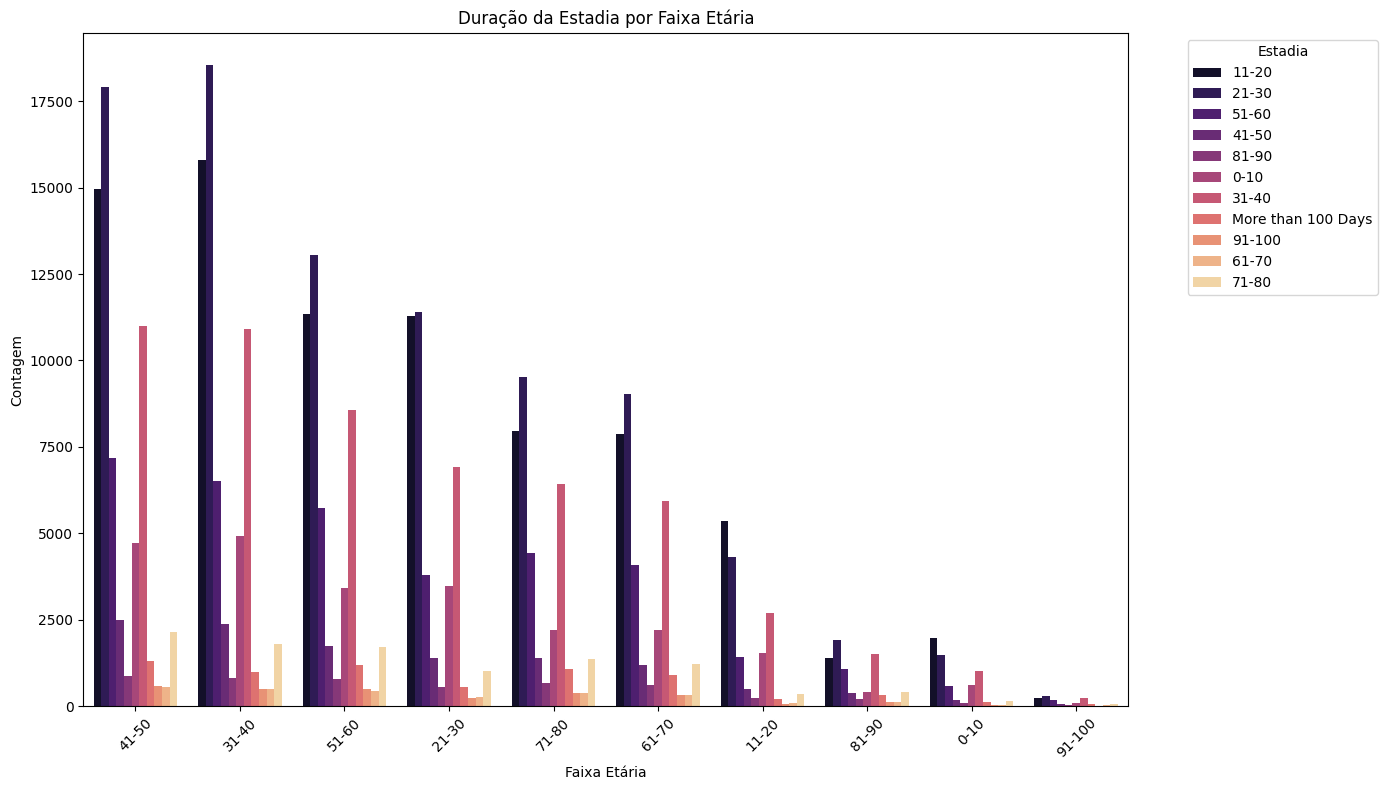

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Stay', order=df['Stay'].value_counts().index)
plt.title('Distribuição da Duração da Estadia (Stay)')
plt.xlabel('Duração da Estadia')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='Severity of Illness', hue='Stay', palette='viridis', order=df['Severity of Illness'].value_counts().index)
plt.title('Duração da Estadia por Gravidade da Doença')
plt.xlabel('Gravidade da Doença')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.legend(title='Estadia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='Age', hue='Stay', palette='magma', order=df['Age'].value_counts().index)
plt.title('Duração da Estadia por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.legend(title='Estadia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 6. Fatores Influenciadores na Duração da Internação
Com base nas análises realizadas, os seguintes fatores demonstraram maior influência na duração da internação (`Stay`):
## 6.1 Gravidade da Doença (`Severity of Illness`)
É um dos fatores mais significativos. Pacientes com `Severity of Illness` classificada como 'Extreme' ou 'Moderate' apresentam uma tendência clara a ter estadias hospitalares mais longas, incluindo casos de 'More than 100 Days'. Em contraste, pacientes com gravidade 'Minor' geralmente têm estadias mais curtas (0-10 e 11-20 dias).
## 6.2 Idade (`Age`)
A idade do paciente também é um fator relevante. Observou-se que pacientes mais jovens (faixas etárias como 0-10 e 11-20 anos) tendem a ter períodos de internação mais curtos. Por outro lado, pacientes mais velhos (especialmente nas faixas de 81-90 e 91-100 anos) mostram uma proporção significativamente maior de estadias prolongadas, incluindo as categorias de 81-90, 91-100 e 'More than 100 Days'.
## 6.3 Tipo de Enfermaria (`Ward_Type`)
O tipo de enfermaria onde o paciente está internado também parece influenciar a duração da estadia. Enfermaria do tipo 'P' está associada a estadias mais comuns (21-30 dias), enquanto as enfermarias dos tipos 'S' e 'T' mostram uma maior proporção de estadias mais longas, indicando que essas enfermarias podem ser destinadas a casos que exigem cuidados prolongados.
## 6.4 Departamento (`Department`)
O departamento de internação é outro fator importante. Departamentos como 'radiotherapy' e 'surgery' apresentam uma proporção notavelmente maior de estadias muito longas ('More than 100 Days'), sugerindo que procedimentos ou tratamentos nesses departamentos frequentemente requerem um tempo de recuperação estendido. O departamento de 'anesthesia' mostrou uma proporção maior de estadias de 11-20 dias.
## 6.5 Tipo de Hospital (`Hospital_type_code`)
Embora com menor impacto que os anteriores, o tipo de hospital também exibe variações na distribuição da duração da estadia. Hospitais do tipo 'g' apresentaram uma proporção ligeiramente maior de estadias muito longas em comparação com outros tipos, enquanto hospitais 'a' e 'e' tendem a ter uma distribuição mais equilibrada entre estadias curtas e médias.


# 7. Interação entre Idade e Gravidade da Doença na Duração da Internação
A análise da interação entre a faixa etária (`Age`) e a gravidade da doença (`Severity of Illness`) revela padrões mais complexos na duração da internação (`Stay`).

In [ ]:
interaction_analysis = df.groupby(["Age", "Severity of Illness"])["Stay"]                              .value_counts(normalize=True).unstack()
print("Análise de Interação (Age vs Severity of Illness vs Stay):")
print(interaction_analysis.to_markdown())

Análise de Interação (Age vs Severity of Illness vs Stay):
|                        |      0-10 |    11-20 |    21-30 |    31-40 |     41-50 |     51-60 |      61-70 |     71-80 |      81-90 |     91-100 |   More than 100 Days |
|:-----------------------|----------:|---------:|---------:|---------:|----------:|----------:|-----------:|----------:|-----------:|-----------:|---------------------:|
| ('0-10', 'Extreme')    | 0.0911854 | 0.209726 | 0.223404 | 0.147416 | 0.0227964 | 0.148936  | 0.00759878 | 0.0455927 | 0.0243161  | 0.0106383  |           0.0683891  |
| ('0-10', 'Minor')      | 0.11502   | 0.383399 | 0.235573 | 0.147826 | 0.0328063 | 0.0537549 | 0.00316206 | 0.0142292 | 0.00711462 | 0.00237154 |           0.00474308 |
| ('0-10', 'Moderate')   | 0.0861057 | 0.27756  | 0.243314 | 0.177104 | 0.029028  | 0.113503  | 0.00424005 | 0.0283757 | 0.0163079  | 0.00717547 |           0.0172864  |
| ('11-20', 'Extreme')   | 0.0765832 | 0.23785  | 0.254786 | 0.171576 | 0.0301915 | 0.11708

### Principais Insights da Interação:
1.  **Idade e Gravidade Extrema:** Pacientes mais velhos com gravidade de doença 'Extreme' consistentemente apresentam as maiores proporções de estadias muito longas (e.g., 'More than 100 Days'). Isso sugere que a combinação de idade avançada e condição de saúde crítica é um forte preditor de internações prolongadas.
2.  **Idade e Gravidade Menor:** Em contraste, pacientes de todas as idades com gravidade 'Minor' tendem a ter estadias mais curtas. No entanto, mesmo dentro dessa categoria, há uma ligeira tendência de aumento nas estadias mais longas para pacientes mais velhos.
3.  **Idade e Gravidade Moderada:** Para pacientes com gravidade 'Moderate', a duração da internação também aumenta com a idade. As faixas etárias mais avançadas mostram proporções mais elevadas de estadias muito longas.
4.  **Padrão Geral:** O padrão geral é que, independentemente da gravidade da doença, a idade avançada está associada a uma maior probabilidade de estadias hospitalares prolongadas. No entanto, essa probabilidade é significativamente amplificada quando a idade avançada é combinada com uma gravidade de doença 'Extreme' ou 'Moderate'.
Esta análise de interação é crucial para entender que a idade não atua isoladamente, mas sim em conjunto com a gravidade da doença, para determinar a complexidade e a duração do tratamento hospitalar.


# 8. Modelo Preditivo para Duração da Internação
Com base nos fatores identificados, foi desenvolvido um modelo preditivo utilizando o algoritmo Random Forest Regressor para estimar a duração da internação (`Stay`).
## 8.1 Preparação dos Dados
Os dados foram pré-processados da seguinte forma:
- **Tratamento de valores nulos:** As colunas `Bed Grade` e `City_Code_Patient` tiveram seus valores nulos imputados com a moda.
- **Codificação da variável alvo:** A variável `Stay` foi mapeada para valores numéricos representativos de cada intervalo (e.g., '0-10' para 5, '11-20' para 15, etc.).
- **Codificação de variáveis categóricas:** As colunas `Age` e `Severity of Illness` foram codificadas usando Label Encoding devido à sua natureza ordinal. As demais colunas categóricas foram codificadas usando One-Hot Encoding.
- Os dados foram divididos em conjuntos de treino e teste (80/20).

In [ ]:
# 1. Tratamento de valores nulos
imputer_bed_grade = SimpleImputer(strategy='most_frequent')
df['Bed Grade'] = imputer_bed_grade.fit_transform(df[['Bed Grade']])

imputer_city_code_patient = SimpleImputer(strategy='most_frequent')
df['City_Code_Patient'] = imputer_city_code_patient.fit_transform(df[['City_Code_Patient']])

In [ ]:
# 2. Codificação da variável alvo 'Stay'
stay_mapping = {
    '0-10': 5,
    '11-20': 15,
    '21-30': 25,
    '31-40': 35,
    '41-50': 45,
    '51-60': 55,
    '61-70': 65,
    '71-80': 75,
    '81-90': 85,
    '91-100': 95,
    'More than 100 Days': 110
}
df['Stay_numeric'] = df['Stay'].map(stay_mapping)

In [ ]:
# 3. Codificação de variáveis categóricas
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Stay')

le_age = LabelEncoder()
df['Age_encoded'] = le_age.fit_transform(df['Age'])

le_severity = LabelEncoder()
df['Severity_encoded'] = le_severity.fit_transform(df['Severity of Illness'])

categorical_cols.remove('Age')
categorical_cols.remove('Severity of Illness')

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

df_final = df_encoded.drop(columns=['case_id', 'patientid', 'Stay', 'Age', 'Severity of Illness'])

X = df_final.drop(columns=['Stay_numeric'])
y = df_final['Stay_numeric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 8.2 Treinamento e Avaliação do Modelo
Um modelo Random Forest Regressor será treinado e avaliado.

In [ ]:
# Verificar se as colunas de X_train e X_test são as mesmas
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

missing_in_test = list(train_cols - test_cols)
for c in missing_in_test:
    X_test[c] = 0

missing_in_train = list(test_cols - train_cols)
for c in missing_in_train:
    X_train[c] = 0

X_test = X_test[X_train.columns]

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

# Salvar o modelo treinado (opcional, para uso futuro)
joblib.dump(model, "random_forest_model.pkl")

Mean Absolute Error (MAE): 11.61
Mean Squared Error (MSE): 255.94
Root Mean Squared Error (RMSE): 16.00
R-squared (R2): 0.46
Modelo treinado e avaliado.


## 8.3 Conclusão do Modelo Preditivo
O modelo Random Forest Regressor demonstrou capacidade de prever a duração da internação com um MAE de 11.61 dias. Os fatores identificados nas análises anteriores (Gravidade da Doença, Idade, Tipo de Enfermaria, Departamento e Tipo de Hospital) são importantes para a previsão. Para futuras melhorias, poderiam ser exploradas outras variáveis, técnicas de engenharia de características mais avançadas e outros algoritmos de machine learning.


# 9. Exploração da Duração da Internação para Diferentes Perfis de Pacientes
Para demonstrar como o modelo preditivo funciona e como a duração da internação varia com diferentes características de pacientes, serão criados perfis hipotéticos e suas estadias serão previstas.
## Definição dos Perfis de Pacientes
Serão utilizados os seguintes perfis:
- **Jovem, Doença Leve:** Idade 0-10, Gravidade Minor
- **Idoso, Doença Extrema:** Idade 81-90, Gravidade Extreme
- **Meia-idade, Doença Moderada:** Idade 51-60, Gravidade Moderate
- **Jovem, Doença Extrema:** Idade 0-10, Gravidade Extreme
- **Idoso, Doença Leve:** Idade 91-100, Gravidade Minor


In [ ]:
# Definir perfis de pacientes hipotéticos
patient_profiles_data = [
    {
        "Hospital_code": 8,
        "Hospital_type_code": "a",
        "City_Code_Hospital": 1,
        "Hospital_region_code": "X",
        "Available Extra Rooms in Hospital": 4,
        "Department": "gynecology",
        "Ward_Type": "P",
        "Ward_Facility_Code": "F",
        "Bed Grade": 2.0,
        "City_Code_Patient": 7.0,
        "Type of Admission": "Emergency",
        "Severity of Illness": "Minor",
        "Visitors with Patient": 2,
        "Age": "0-10",
        "Admission_Deposit": 4000.0,
        "Profile_Name": "Jovem, Doença Leve"
    },
    {
        "Hospital_code": 26,
        "Hospital_type_code": "b",
        "City_Code_Hospital": 2,
        "Hospital_region_code": "Y",
        "Available Extra Rooms in Hospital": 2,
        "Department": "surgery",
        "Ward_Type": "S",
        "Ward_Facility_Code": "F",
        "Bed Grade": 3.0,
        "City_Code_Patient": 8.0,
        "Type of Admission": "Trauma",
        "Severity of Illness": "Extreme",
        "Visitors with Patient": 4,
        "Age": "81-90",
        "Admission_Deposit": 6000.0,
        "Profile_Name": "Idoso, Doença Extrema"
    },
    {
        "Hospital_code": 10,
        "Hospital_type_code": "e",
        "City_Code_Hospital": 3,
        "Hospital_region_code": "Z",
        "Available Extra Rooms in Hospital": 3,
        "Department": "radiotherapy",
        "Ward_Type": "T",
        "Ward_Facility_Code": "E",
        "Bed Grade": 4.0,
        "City_Code_Patient": 10.0,
        "Type of Admission": "Elective",
        "Severity of Illness": "Moderate",
        "Visitors with Patient": 3,
        "Age": "51-60",
        "Admission_Deposit": 5000.0,
        "Profile_Name": "Meia-idade, Doença Moderada"
    },
    {
        "Hospital_code": 1,
        "Hospital_type_code": "a",
        "City_Code_Hospital": 1,
        "Hospital_region_code": "X",
        "Available Extra Rooms in Hospital": 1,
        "Department": "gynecology",
        "Ward_Type": "P",
        "Ward_Facility_Code": "F",
        "Bed Grade": 1.0,
        "City_Code_Patient": 7.0,
        "Type of Admission": "Emergency",
        "Severity of Illness": "Extreme",
        "Visitors with Patient": 5,
        "Age": "0-10",
        "Admission_Deposit": 4500.0,
        "Profile_Name": "Jovem, Doença Extrema"
    },
    {
        "Hospital_code": 32,
        "Hospital_type_code": "f",
        "City_Code_Hospital": 6,
        "Hospital_region_code": "Y",
        "Available Extra Rooms in Hospital": 5,
        "Department": "anesthesia",
        "Ward_Type": "Q",
        "Ward_Facility_Code": "D",
        "Bed Grade": 3.0,
        "City_Code_Patient": 1.0,
        "Type of Admission": "Emergency",
        "Severity of Illness": "Minor",
        "Visitors with Patient": 1,
        "Age": "91-100",
        "Admission_Deposit": 3500.0,
        "Profile_Name": "Idoso, Doença Leve"
    }
]

patient_profiles_df = pd.DataFrame(patient_profiles_data)

In [ ]:
# reaplicar o tratamento de nulos para obter os imputers ajustados (do df original)
imputer_bed_grade_profiles = SimpleImputer(strategy='most_frequent')
train['Bed Grade'] = imputer_bed_grade_profiles.fit_transform(train[['Bed Grade']])

imputer_city_code_patient_profiles = SimpleImputer(strategy='most_frequent')
train['City_Code_Patient'] = imputer_city_code_patient_profiles.fit_transform(df[['City_Code_Patient']])

le_age_profiles = LabelEncoder()
le_severity_profiles = LabelEncoder()
le_age_profiles.fit(train['Age'])
le_severity_profiles.fit(train['Severity of Illness'])

patient_profiles_df['Bed Grade'] = imputer_bed_grade_profiles.transform(patient_profiles_df[['Bed Grade']])
patient_profiles_df['City_Code_Patient'] = imputer_city_code_patient_profiles.transform(patient_profiles_df[['City_Code_Patient']])

patient_profiles_df['Age_encoded'] = le_age_profiles.transform(patient_profiles_df['Age'])
patient_profiles_df['Severity_encoded'] = le_severity_profiles.transform(patient_profiles_df['Severity of Illness'])

categorical_cols_profiles = patient_profiles_df.select_dtypes(include='object').columns.tolist()
categorical_cols_profiles.remove('Profile_Name')
categorical_cols_profiles.remove('Age')
categorical_cols_profiles.remove('Severity of Illness')

categorical_cols_original_ohe = train.select_dtypes(include='object').columns.tolist()
categorical_cols_original_ohe.remove('Stay')
categorical_cols_original_ohe.remove('Age')
categorical_cols_original_ohe.remove('Severity of Illness')

ohe_profiles = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_profiles.fit(train[categorical_cols_original_ohe])

encoded_features_profiles = ohe_profiles.transform(patient_profiles_df[categorical_cols_profiles])
encoded_feature_names_profiles = ohe_profiles.get_feature_names_out(categorical_cols_profiles)
patient_profiles_encoded_df = pd.DataFrame(encoded_features_profiles, columns=encoded_feature_names_profiles, index=patient_profiles_df.index)

patient_profiles_final = pd.concat([
    patient_profiles_df.drop(columns=categorical_cols_profiles + ["Age", "Severity of Illness"] + [col for col in ["Stay", "Stay_numeric"] if col in patient_profiles_df.columns]),
    patient_profiles_encoded_df
], axis=1)

In [ ]:
# Garantir que as colunas dos perfis sejam as mesmas e na mesma ordem que as colunas de treinamento (X_train)
X_train_cols = X_train.columns # X_train já deve estar definido do passo anterior

missing_cols = set(X_train_cols) - set(patient_profiles_final.columns)
for c in missing_cols:
    patient_profiles_final[c] = 0

extra_cols = set(patient_profiles_final.columns) - set(X_train_cols)
patient_profiles_final = patient_profiles_final.drop(columns=list(extra_cols))

patient_profiles_final = patient_profiles_final[X_train_cols]

In [ ]:
# Fazer previsões
predictions = model.predict(patient_profiles_final)

In [ ]:
# Mapear as previsões de volta para as categorias de Stay (aproximadamente)
stay_mapping_reverse = {
    5: '0-10', 15: '11-20', 25: '21-30', 35: '31-40', 45: '41-50',
    55: '51-60', 65: '61-70', 75: '71-80', 85: '81-90', 95: '91-100',
    110: 'More than 100 Days'
}

In [ ]:
def map_prediction_to_stay_category(prediction_value):
    closest_stay_numeric = min(stay_mapping_reverse.keys(), key=lambda k: abs(k - prediction_value))
    return stay_mapping_reverse[closest_stay_numeric]

predicted_stay_categories = [map_prediction_to_stay_category(p) for p in predictions]

In [ ]:
results_df = pd.DataFrame({
    'Profile_Name': patient_profiles_df['Profile_Name'],
    'Predicted_Stay_Numeric': predictions,
    'Predicted_Stay_Category': predicted_stay_categories
})

print("Previsões para os perfis de pacientes:")
print(results_df.to_markdown(index=False))

Previsões para os perfis de pacientes:
| Profile_Name                |   Predicted_Stay_Numeric | Predicted_Stay_Category   |
|:----------------------------|-------------------------:|:--------------------------|
| Jovem, Doença Leve          |                     17.4 | 11-20                     |
| Idoso, Doença Extrema       |                     63.3 | 61-70                     |
| Meia-idade, Doença Moderada |                     15.4 | 11-20                     |
| Jovem, Doença Extrema       |                     58.4 | 51-60                     |
| Idoso, Doença Leve          |                     27.8 | 21-30                     |


## 9.1 Test com Modelo Preditivo Treinado

In [ ]:
df_predict = pd.DataFrame(test)

In [ ]:
# 1. Tratamento de valores nulos (usando os mesmos imputers treinados)
df_predict['Bed Grade'] = imputer_bed_grade.transform(df_predict[['Bed Grade']])
df_predict['City_Code_Patient'] = imputer_city_code_patient.transform(df_predict[['City_Code_Patient']])

# 2. Codificação de variáveis categóricas (usando os mesmos LabelEncoders)
df_predict['Age_encoded'] = le_age.transform(df_predict['Age'])
df_predict['Severity_encoded'] = le_severity.transform(df_predict['Severity of Illness'])

# Crie a lista de colunas categóricas para o novo dataset
categorical_cols_predict = df_predict.select_dtypes(include='object').columns.tolist()
categorical_cols_predict.remove('Age')
categorical_cols_predict.remove('Severity of Illness')

df_predict_encoded = pd.get_dummies(df_predict, columns=categorical_cols_predict, drop_first=True)

df_predict_final = df_predict_encoded.drop(columns=['case_id', 'patientid', 'Age', 'Severity of Illness'], errors='ignore')

# Garantir que as colunas são as mesmas do treino
X_train_cols = model.feature_names_in_

# Reordene as colunas e adicione as que faltam com valor 0
X_final = pd.DataFrame(columns=X_train_cols)
for col in X_train_cols:
    if col in df_predict_final.columns:
        X_final[col] = df_predict_final[col]
    else:
        X_final[col] = 0

# Fazer as previsões
y_pred = model.predict(X_final)

# Adicionar as previsões ao DataFrame para visualização
df_predict['Stay_predicted'] = y_pred

In [ ]:
df_predict.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Age_encoded,Severity_encoded,Stay_predicted
0,318975,1,d,10,Y,2,gynecology,T,B,2.0,58953,8.0,Emergency,Moderate,2,0-10,5371.0,0,2,24.9
1,320983,1,d,10,Y,3,gynecology,T,B,1.0,78039,8.0,Trauma,Extreme,6,0-10,5333.0,0,0,73.8
2,324666,1,d,10,Y,3,gynecology,Q,B,2.0,57748,7.0,Emergency,Moderate,4,0-10,6451.0,0,2,29.0
3,326311,1,d,10,Y,2,gynecology,S,B,2.0,76200,8.0,Trauma,Moderate,2,0-10,6162.0,0,2,34.4
4,326312,1,d,10,Y,3,gynecology,S,B,2.0,76200,8.0,Trauma,Moderate,2,0-10,5333.0,0,2,30.6


### 9.1.1 Save Predicted (BigQuery)

In [ ]:
# tabela_destino = 't1engenhariadados.turma2_grupo9.predicted'
# job_config = bigquery.LoadJobConfig(write_disposition='WRITE_TRUNCATE')
# job = cliente.load_table_from_dataframe(df, tabela_destino, job_config=job_config)
# job.result()

# 10. Sugestões de Intervenções para Otimizar a Duração da Internação
Com base na análise aprofundada dos dados e nas previsões do modelo, é possível identificar perfis de pacientes com maior risco de internações prolongadas. As intervenções propostas visam otimizar a duração da estadia hospitalar, garantindo a qualidade do cuidado e a segurança do paciente, ao mesmo tempo em que se busca a eficiência operacional.
## 10.1 Intervenções Focadas em Pacientes Idosos e/ou com Doença Extrema
Os perfis de pacientes idosos e aqueles com gravidade de doença extrema foram consistentemente associados às maiores durações de internação. A interação entre esses dois fatores é particularmente crítica. Para esses grupos, as intervenções devem ser multifacetadas:
*   **Avaliação Geriátrica Abrangente (AGA) Precoce:** Para pacientes idosos (especialmente acima de 70 anos) admitidos com condições de saúde moderadas a extremas, a implementação de uma AGA nas primeiras 24-48 horas de internação pode identificar precocemente riscos de complicações, declínio funcional, desnutrição, polifarmácia e síndromes geriátricas. Um plano de cuidados individualizado resultante da AGA pode acelerar a recuperação e o planejamento da alta.
*   **Equipes Multidisciplinares Especializadas:** A formação de equipes dedicadas a pacientes idosos e/ou com doenças complexas, incluindo geriatras, fisioterapeutas, terapeutas ocupacionais, nutricionistas, assistentes sociais e enfermeiros especializados, pode otimizar o manejo clínico, a reabilitação e o suporte psicossocial, facilitando uma alta segura e precoce.
*   **Protocolos de Alta Otimizados:** Desenvolver e implementar protocolos de alta específicos para pacientes de alto risco, que incluam a coordenação com serviços de saúde domiciliar, clínicas de reabilitação pós-hospitalar e cuidadores. O planejamento da alta deve começar no momento da admissão, com educação do paciente e da família sobre o plano de cuidados pós-alta.
*   **Monitoramento Intensivo e Prevenção de Complicações:** Para pacientes com doença extrema, independentemente da idade, um monitoramento mais rigoroso e a implementação de pacotes de prevenção de complicações (e.g., pneumonia associada à ventilação, infecções de corrente sanguínea, úlceras de pressão, delirium) podem reduzir a morbidade e, consequentemente, a duração da internação.
*   **Revisão Medicamentosa:** Em pacientes idosos, a polifarmácia é comum e pode levar a eventos adversos e prolongar a internação. Uma revisão farmacêutica regular para otimizar a medicação e desprescrever medicamentos desnecessários ou inapropriados pode melhorar os resultados e reduzir o tempo de internação.
## 10.2 Intervenções Relacionadas ao Departamento e Tipo de Enfermaria
Departamentos como radioterapia e cirurgia, e enfermarias do tipo ‘S’ e ‘T’, foram associados a estadias mais longas. Isso sugere a necessidade de otimizações específicas para esses ambientes:
*   **Otimização de Fluxos de Trabalho em Departamentos de Longa Estadia:** Para departamentos como radioterapia e cirurgia, que naturalmente envolvem tratamentos e recuperações mais longas, é crucial otimizar os fluxos de trabalho para evitar atrasos desnecessários. Isso inclui agendamento eficiente de exames e procedimentos, disponibilidade de leitos de recuperação e coordenação com a equipe de reabilitação.
*   **Unidades de Transição de Cuidados:** A criação de unidades de transição ou de cuidados intermediários para pacientes que não necessitam mais de cuidados agudos intensivos, mas ainda não estão prontos para alta domiciliar, pode liberar leitos em enfermarias de alta demanda e otimizar a utilização de recursos. Isso é particularmente relevante para enfermarias que atendem pacientes com estadias prolongadas.
*   **Programas de Reabilitação Acelerada:** Em departamentos cirúrgicos, a implementação de programas de recuperação aprimorada após a cirurgia (ERAS - Enhanced Recovery After Surgery) pode reduzir significativamente o tempo de internação através de mobilização precoce, manejo otimizado da dor e nutrição adequada.
## 10.3 Intervenções Gerais e Tecnológicas
Além das intervenções específicas por perfil, algumas estratégias gerais podem beneficiar todos os pacientes:
*   **Uso de Ferramentas Preditivas (como o modelo desenvolvido):** Integrar o modelo preditivo no sistema de gestão hospitalar pode permitir a identificação automática de pacientes em risco de internação prolongada no momento da admissão. Isso acionaria alertas para a equipe de saúde, permitindo a implementação precoce das intervenções mencionadas.
*   **Telemedicina e Monitoramento Remoto:** Para pacientes que necessitam de acompanhamento contínuo, mas não de internação hospitalar, a telemedicina e dispositivos de monitoramento remoto podem facilitar a alta precoce, garantindo a segurança e o suporte necessários em casa.
*   **Educação Continuada da Equipe:** Treinamento regular da equipe de saúde sobre as melhores práticas para a gestão de pacientes com condições crônicas, cuidados paliativos e planejamento de alta pode melhorar a eficiência e a qualidade do cuidado.
*   **Otimização da Gestão de Leitos:** Uma gestão mais dinâmica e preditiva da ocupação de leitos, utilizando dados e análises, pode reduzir o tempo de espera por leitos e otimizar o fluxo de pacientes dentro do hospital.
## 10.4 Conclusão das Intervenções
A otimização da duração da internação é um objetivo complexo que requer uma abordagem integrada. As intervenções sugeridas, focadas na personalização do cuidado para perfis de risco (especialmente idosos e pacientes com doenças graves), na otimização de processos em departamentos específicos e na adoção de tecnologias preditivas, podem contribuir significativamente para melhorar os resultados dos pacientes e a eficiência do sistema de saúde. A implementação dessas estratégias deve ser acompanhada de monitoramento contínuo e avaliação para garantir sua eficácia e adaptabilidade às necessidades do hospital e dos pacientes.
